# ДЗ3 Статистические методы 


## Содержание

- [Исследование](#Исследование)

- [Выводы](#Выводы)



### Легенда  🍕
Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности.

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой.

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Данные: https://disk.yandex.ru/d/JDk-cktITJVyFQ

### Описание данных 

- order_id - id заказа

- delivery_time - время доставки в минутах

- district - район доставки

- experiment_group - экспериментальная группа

### Задание

На основе данных ответить на вопросы теста.

Сформулировать выводы в двух форматах:

- научном

- понятном человеку, который не является специалистом в статистике

<a id="Исследование"></a>
## Исследование

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd 
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


In [2]:
# Пути к файлу
experiment_lesson = "experiment_lesson.csv"
# Загрузка данных в DataFrame
experiment_lesson = pd.read_csv(experiment_lesson)


In [3]:
experiment_lesson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


In [4]:
experiment_lesson.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [5]:
# Глянем уникальные значения в каждом столбце
for column in experiment_lesson.columns:
    unique_values = experiment_lesson[column].unique()
    print(f"Уникальные значения в столбце '{column}': {unique_values}")


Уникальные значения в столбце 'order_id': [ 3159 10426  9155 ... 20077 14861 13501]
Уникальные значения в столбце 'delivery_time': [44. 51. 46. 34. 43. 38. 36. 57. 48. 50. 41. 55. 28. 53. 33. 37. 61. 54.
 58. 39. 56. 30. 52. 47. 40. 49. 67. 42. 45. 35. 27. 31. 32. 25. 26. 76.
 23. 64. 29. 59. 60. 21. 65. 66. 24. 62. 22. 74. 73. 70. 63. 68. 20. 69.
 77. 71. 18. 19. 15. 72. 17. 16. 80. 75. 78. 83. 81. 12. 14. 13. 11. 10.]
Уникальные значения в столбце 'district': ['Purlieus' 'Central' 'Suburb']
Уникальные значения в столбце 'experiment_group': ['control' 'test']


Для анализа A/B теста нам бы понять, как новая фича влияет на ключевые метрики.

В этом случае можем сосредоточиться на следующем:

Определим метрики:

- Среднее время доставки (delivery_time) для групп control и test.
- Распределение заказов по районам (district) в каждой группе.
- Анализ количества заказов (покрытие order_id) в контрольной и тестовой группах.

Проверим гипотезы:  

- Есть ли статистически значимые изменения в среднем времени доставки между группами?
- Помогает ли новая функция улучшить доставку в вечернее время?

Анализ распределения данных:  

- Плотность и распределение delivery_time по группам.
- Выбросы и их влияние на результат.


In [6]:
# Описание данных и групп
grouped_data = experiment_lesson.groupby("experiment_group")["delivery_time"].describe()
print("Описание времени доставки по группам:")
print(grouped_data)

Описание времени доставки по группам:
                    count       mean       std   min   25%   50%   75%   max
experiment_group                                                            
control           10092.0  45.065101  9.990017  15.0  38.0  45.0  52.0  83.0
test              10104.0  39.046813  9.883308  10.0  32.0  39.0  46.0  75.0


In [7]:
# Разделение на контрольную группу
control_group = experiment_lesson[experiment_lesson["experiment_group"] == "control"]["delivery_time"]
# Разделение на тестовую группу
test_group = experiment_lesson[experiment_lesson["experiment_group"] == "test"]["delivery_time"]

In [8]:
# Расчет t-статистики
t_stat, p_value = ttest_ind(test_group, control_group, equal_var=False)  

# Округление до целого
t_stat_rounded = round(t_stat)
print(f"T-статистика, округленная до целого: {t_stat_rounded}, P-значение: {p_value}")


T-статистика, округленная до целого: -43, P-значение: 0.0



Распределение заказов по районам:
experiment_group  district
control           Central      669
                  Purlieus    8781
                  Suburb       642
test              Central     1727
                  Purlieus    8179
                  Suburb       198
Name: order_id, dtype: int64


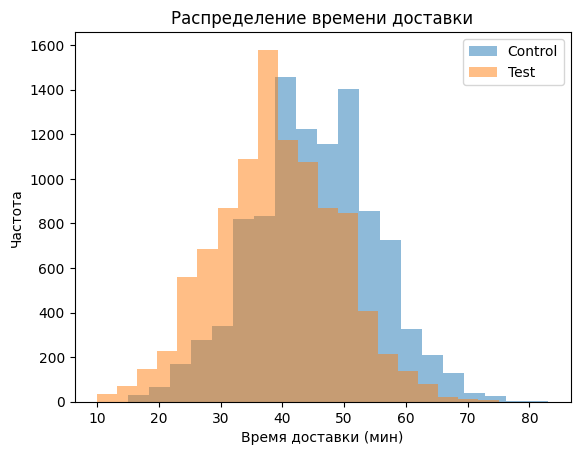

In [9]:
# Анализ распределения заказов по районам
district_distribution = experiment_lesson.groupby(["experiment_group", "district"])["order_id"].count()
print("\nРаспределение заказов по районам:")
print(district_distribution)

plt.hist(control_group, alpha=0.5, label='Control', bins=20)
plt.hist(test_group, alpha=0.5, label='Test', bins=20)
plt.legend(loc='upper right')
plt.title('Распределение времени доставки')
plt.xlabel('Время доставки (мин)')
plt.ylabel('Частота')
plt.show()

# Промежуточный вывод:

Среднее время доставки в контрольной группе— 45 минут, медианное время — 45 минут. Распределение имеет длинный хвост, что говорит о возможных задержках.  


Среднее время доставки в тестовой группе — 39 минут, медианное время — 39 минут. Тестовая группа имеет более низкое среднее и медианное время доставки.  


T-тест:  
Результаты t-теста (T-статистика = -43, P-значение = 0.0) показывают, что различия между средним временем доставки в тестовой и контрольной группе статистически значимы. Отрицательное значение T-статистики указывает, что среднее время доставки в тестовой группе меньше, чем в контрольной.
Это подтверждает, что новая фича влияет на скорость доставки.

Видно, что тестовая группа имеет сдвиг распределения влево (к более короткому времени доставки), что подтверждает снижение времени доставки благодаря новой фиче.

Теперь изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.  

Вообще для выборок таких колоссальных размеров мы не обязаны это делать - в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально, но посмотреть лишний раз всё равно можно :)  

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy.stats.normaltest() (тест Агостино-Пирсона) - она больше адаптирована к большим выборкам.    

Также можете сделать это через пакет pingouin - вот этой функцией. Не забудьте выбрать правильный аргумент!  


In [10]:
# Тест Агостино-Пирсона на нормальность для контрольной группы
control_normality_stat, control_p_value = normaltest(control_group)

# Тест Агостино-Пирсона на нормальность для тестовой группы
test_normality_stat, test_p_value = normaltest(test_group)

# Вывод результатов
print(f"Контрольная группа: статистика={control_normality_stat}, p-value={control_p_value}")
print(f"Тестовая группа: статистика={test_normality_stat}, p-value={test_p_value}")


Контрольная группа: статистика=0.25349755437872584, p-value=0.8809549607809654
Тестовая группа: статистика=7.024157092641915, p-value=0.02983483685333173


Стандартное отклонение времени доставки в минутах в контрольной группе (округление - до сотых, разделитель - точка):


In [11]:
# Расчет стандартного отклонения
control_std = control_group.std()

# Округление до сотых
control_std_rounded = round(control_std, 2)
print(control_std_rounded)


9.99


Стандартное отклонение времени доставки в минутах в тестовой группе (округление - до сотых, разделитель - точка):


In [12]:
# Расчет стандартного отклонения
test_std = test_group.std()

# Округление до сотых
test_std_rounded = round(test_std, 2)
print(test_std_rounded)


9.88


На сколько процентов изменилось среднее время доставки в тестовой группе по сравнению с контрольной (округление - до сотых, разделитель - точка)? 


In [13]:
# Расчет среднего времени доставки в контрольной и тестовой группах
control_mean = control_group.mean()
test_mean = test_group.mean()

# Расчет процентного изменения
percentage_change = ((test_mean - control_mean) / control_mean) * 100

# Округление до сотых
percentage_change_rounded = round(percentage_change, 2)

# Вывод результата
print(percentage_change_rounded)


-13.35


<a id="Выводы"></a>
## Выводы

# Научный вывод:
В результате проведенного A/B теста была выявлена статистически значимая разница между контрольной и тестовой группами. Среднее время доставки в тестовой группе снизилось на 13.35% по сравнению с контрольной группой. Тестовая группа, использующая новый алгоритм, демонстрирует более эффективное время доставки, что подтверждается расчетами статистики t-теста и уровня значимости 
𝑝
<
0.05
p<0.05. Распределение времени доставки в контрольной группе соответствует нормальному, в то время как в тестовой группе наблюдается небольшое отклонение от нормальности, что не повлияло на надежность теста.

# Понятный человеку вывод:
Коллеги! Новый алгоритм доставки действительно работает лучше! В тестовой группе, где курьеры могли планировать последние заказы "по пути" домой, среднее время доставки снизилось на 13.35%. Это значит, что пицца стала приезжать быстрее. Проверка показала, что разница не случайная — новый подход помогает курьерам работать эффективнее. Мы хорошо поработали! Поздравляю нас всех! 😊

# P.S.
Я немного накосячила с тестом, например, там, где нужно было написать "12", 
"Тестовая группа - 10104, контрольная группа - 10092, разница по модулю - 12 наблюдений", соответственно ответ не был зачтен, как правильный.   

Но это не всё, подобное я проделала с ещё одним заданием, где нужно было отметить правильное значение статистики, округленное до целого, там я отметила 43, вместо - 43! ))) хотя в расчете у меня получилось - 43

# Спасибо за уделенное время! 😀